### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Training

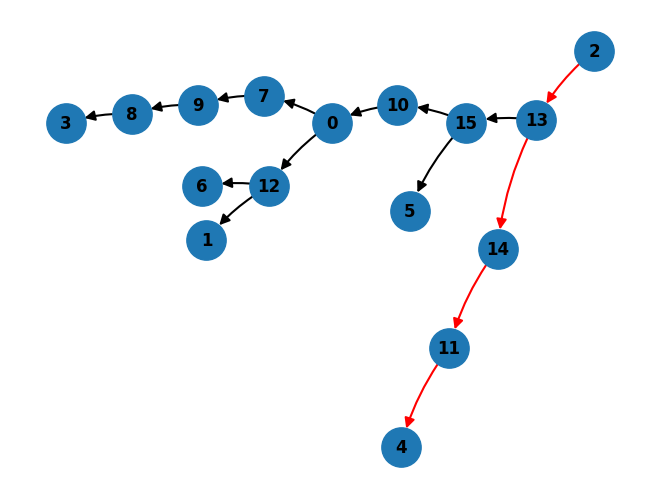

In [2]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [3]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [4]:
model_name="model.pt"

In [5]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), model_name)

In [6]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%
random: 99.9000%


In [7]:
labels, cache = get_example_cache(pred, model, dataset)

In [8]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

### Experiment: understanding embeddings

In [9]:
def generate_goal_distance_examples(distance):
    # Generate clean and corrupted prompts
    clean_prompt = "0>1,1>2,2>3,3>4,4>5,5>6,6>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15"
    edges = [f"{i}>{i+1}" for i in range(15 - distance - 1)] + [f"{15 - distance - 1}>{15 - distance}", f"{15 - distance - 1}>{15 - distance + 1}"] + [f"{i}>{i+1}" for i in range(15 - distance + 1, 15)]
    path = '>'.join([str(x) for x in range(16) if x != 15 - distance])
    corrupted_prompt = ",".join(edges) + "|" + f"{15}:{path}"
    return clean_prompt, corrupted_prompt

In [10]:
for i in range(16):
    clean_prompt, corrupted_prompt= generate_goal_distance_examples(i)
    logit_lens(corrupted_prompt, model, dataset)

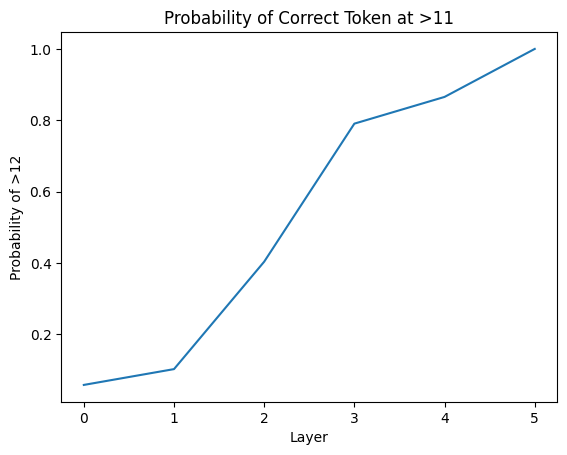

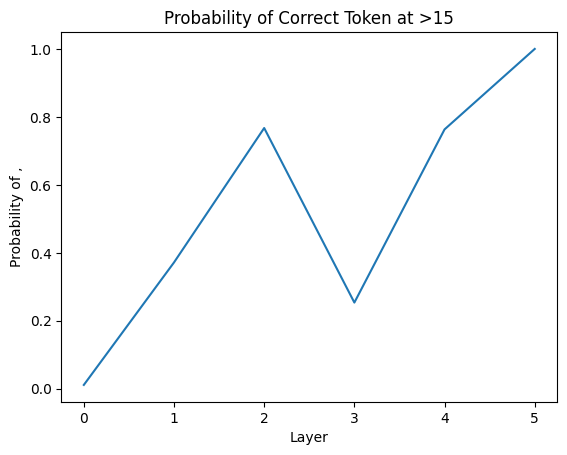

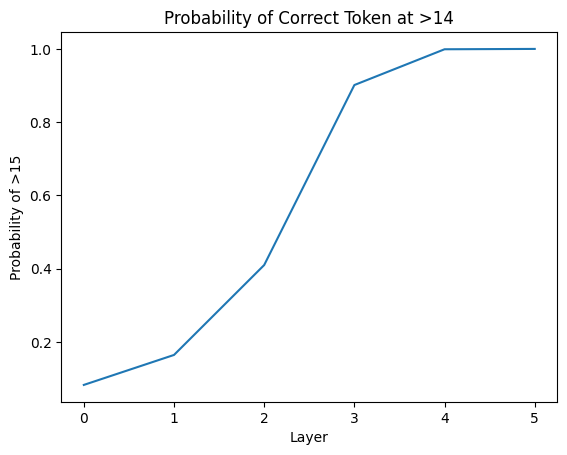

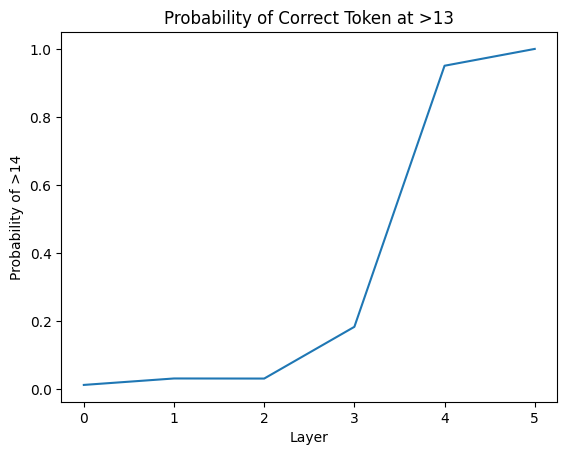

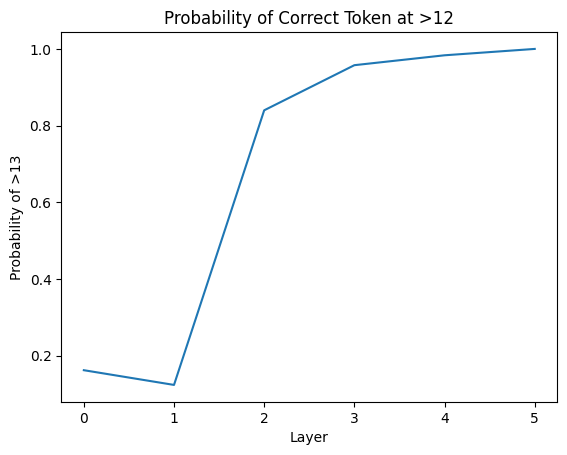

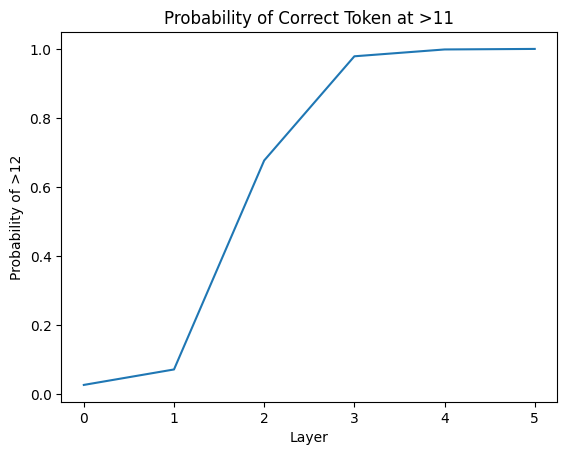

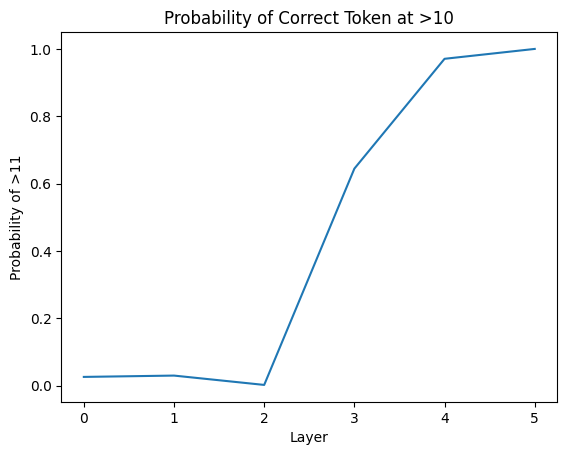

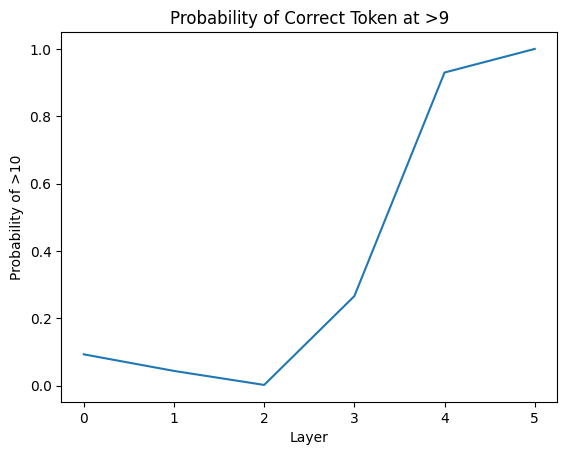

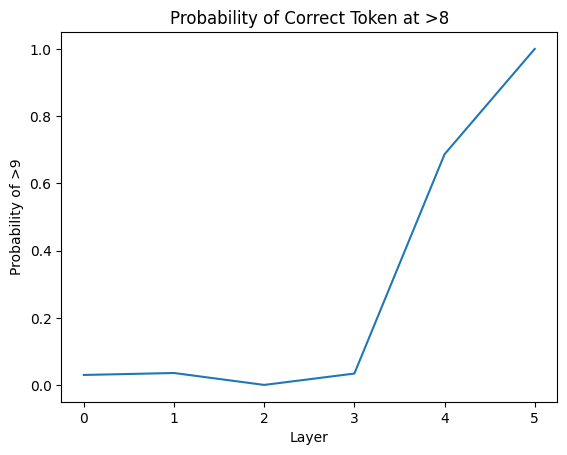

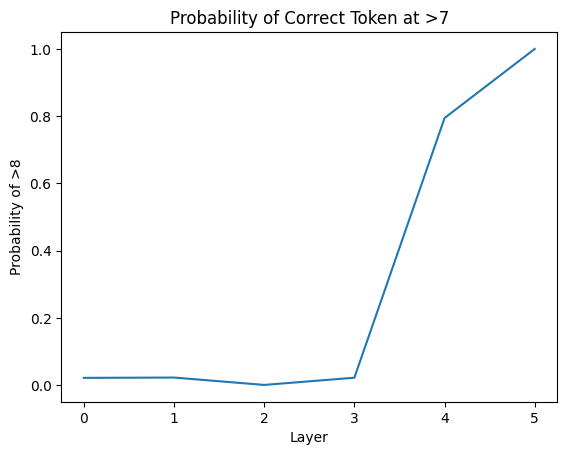

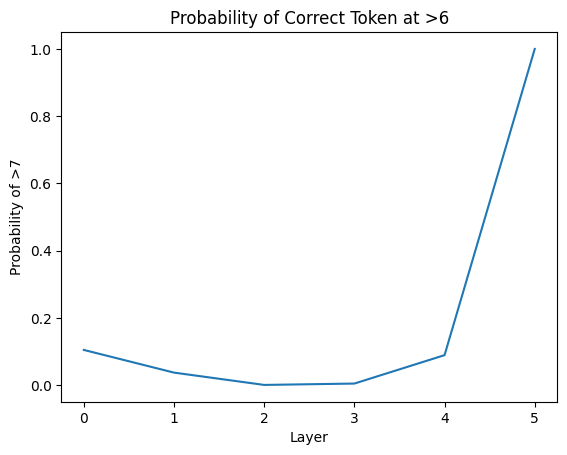

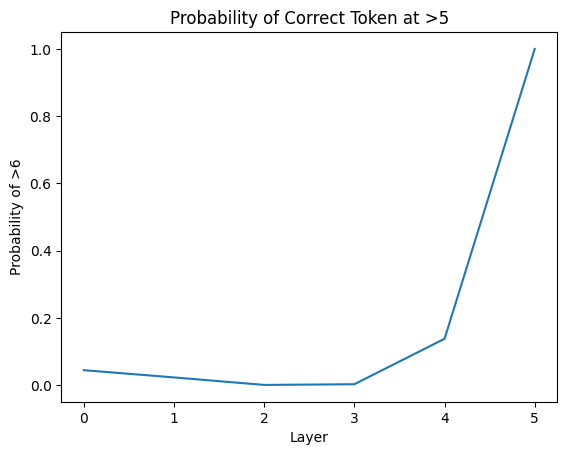

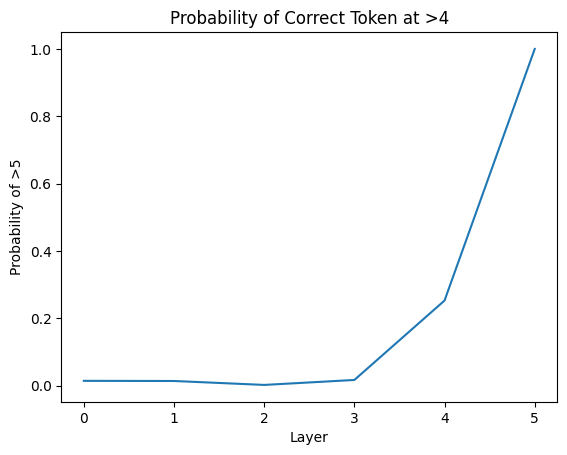

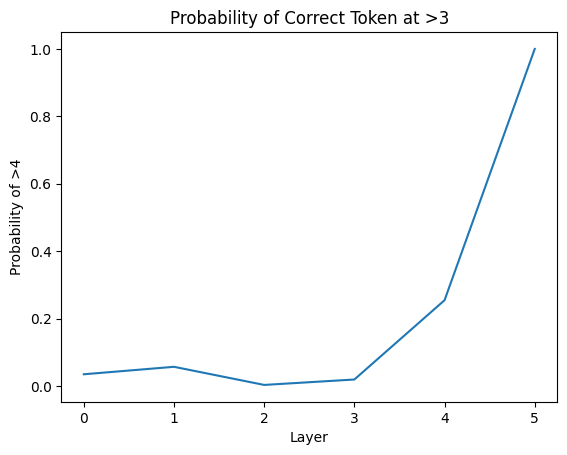

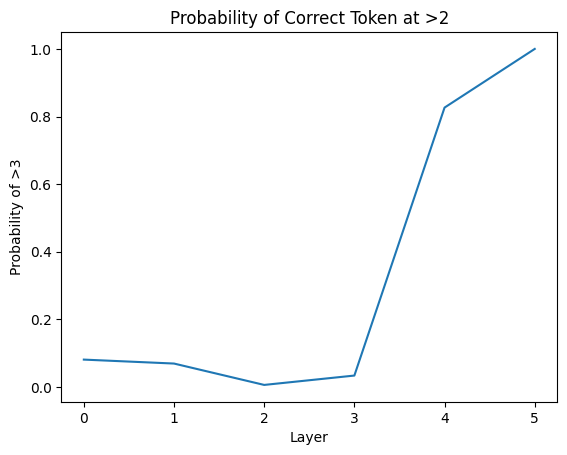

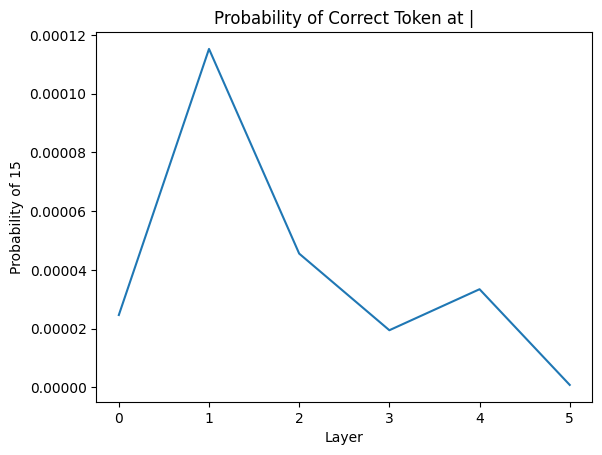

In [11]:
for i in range(16):
    clean_prompt, corrupted_prompt= generate_goal_distance_examples(i)
    logit_lens_correct_probs(corrupted_prompt, model, dataset,46 + (15 - i + 1))

In [12]:
probs=[]
for i in range(15):
    clean_prompt, corrupted_prompt= generate_goal_distance_examples(i)
    probs.append(logit_lens_correct_probs_result(corrupted_prompt, model, dataset,46 + (15 - i + 1)))


In [13]:
px.imshow(probs)

In [14]:
lenses = calculate_tuned_lens(model, dataset)

0.574090712546428
0.5922414723671522
0.6280943762110162
0.7386444222962905
0.8757297331700407
0.9774145783426428


In [15]:
probs_tuned_lens=[]
for i in range(15):
    clean_prompt, corrupted_prompt= generate_goal_distance_examples(i)
    probs_tuned_lens.append(logit_lens_correct_probs_result(corrupted_prompt, model, dataset,46 + (15 - i + 1),lenses=lenses))

In [16]:
px.imshow(probs_tuned_lens)

In [17]:
test_graph = generate_example(n_states, np.random.randint(400_000, 600_000), order="backward")

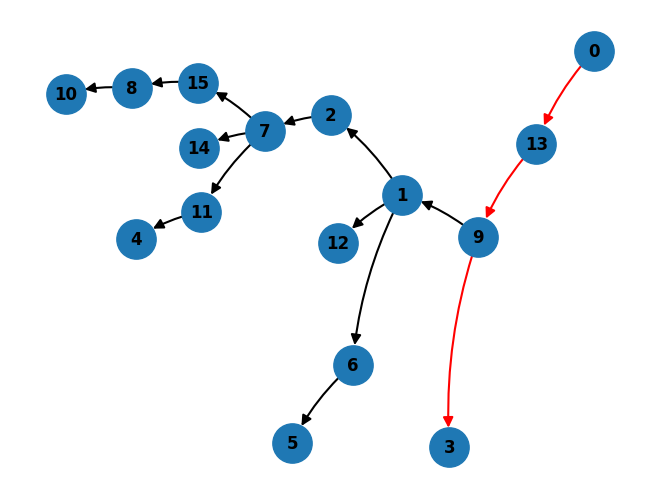

In [18]:
parse_example(test_graph)

In [30]:
probs_random_example=[]
for i in range(15):
    probs_random_example.append(logit_lens_correct_probs_result(test_graph, model, dataset,46 + (15 - i + 1)))


In [20]:
logit_lens(test_graph, model, dataset)

In [33]:
logit_lens(test_graph, model, dataset,lenses=lenses)

In [28]:
probs_random_example_tuned=[]
for i in range(15):
    probs_random_example_tuned.append(logit_lens_correct_probs_result(test_graph, model, dataset,46 + (15 - i + 1),lenses=lenses))


In [32]:
px.imshow(probs_random_example)

In [46]:
def tuned_lens_correct(pred, model, dataset, position, lenses):
    # Get labels and cache
    labels, cache = get_example_cache(pred, model, dataset)
    # Get the probability of the correct next token at every layer
    probs = []
    correct_token = labels[position+1]
    correct_token_idx = dataset.tokens2idx[correct_token]
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        out_proj = res_stream @ lenses[act_name]
        out_proj_index = torch.argmax(out_proj[position])
        probs.append(int(correct_token_idx == out_proj_index))
    # Plot data
    return probs

In [47]:
result_tuned_lens=[]
for i in range(15):
    clean_prompt, corrupted_prompt= generate_goal_distance_examples(i)
    result_tuned_lens.append(tuned_lens_correct(corrupted_prompt, model, dataset,46 + (15 - i + 1),lenses=lenses))

In [50]:
px.imshow(result_tuned_lens)